In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 2.8MB/s 


In [0]:
import pandas as pd
link_hilstrom = 'https://drive.google.com/open?id=15osyN4c5z1pSo1JkxwL_N8bZTksRvQuU'
fluff, id = link_hilstrom.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Hillstrom.csv')
hillstrom_df = pd.read_csv('Hillstrom.csv')

In [0]:
import pandas as pd
link_ = 'https://drive.google.com/open?id=1b8N7WtwIe2WmQJD1KL5UAy70K13MxwKj'
fluff, id = link_.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Lalonde.csv')
lalonde_df = pd.read_csv('Lalonde.csv')

In [0]:
def preprocess_data(df, dataset='hillstrom', verbose=True):
    """
    Preprocessing the dataset
     - Use one-hot encoding for categorical features
     - Check the name of the target variable and treatment variable
     - Drop the unused columns
     - Delete the unused data
    Args:
        df: A pandas.DataFrame which have all data of the dataset
        dataset: the name of the dataset
    Return:
        # I recommend to split into the data frames of predictor variables,
        # the target variable, and the treatment variable
        # df: the data frames of predictor variables
        # df['T']: target variables
        # df['Y']: treatment variables
    """
    if dataset in ['hillstrom', 'email']:
        # For Hillstrom dataset, the ‘‘visit’’ target variable was selected
        #   as the target variable of interest and the selected treatment is
        #   the e-mail campaign for women’s merchandise [1]
        # [1] Kane K, Lo VSY, Zheng J. True-lift modeling: Comparison of methods.
        #    J Market Anal. 2014;2:218–238

        # Delete unused data: men's email cases should be removed
        df = df[df.segment != 'Mens E-Mail'].reset_index()
        # Assign Y for target (visit: 0, 1)
        df['Y'] = df['visit']
        # Assign T for treatment (segment: Womens E-Mail, Mens E-Mail (not used), No E-Mail)
        df['T'] = (df['segment'] == 'Womens E-Mail').astype('int64')
        # Drop unused columns from X
        df = df.drop(columns=['conversion', 'spend', 'visit', 'segment', 'index'])
        # One-hot encoding for categorical features
        df = pd.get_dummies(df)

    elif dataset in ['criteo', 'ad']:
        raise NotImplementedError

    elif dataset in ['lalonde', 'job']:
        # Delete unused data: None
        df = df.reset_index()
        # Target variables (RE78: earnings in 1978)
        df['Y'] = df['RE78']
        # Treatment variables (treatment: 0, 1)
        df['T'] = df['treatment']
        # Drop unused columns
        df = df.drop(columns=['treatment', 'RE78', 'index'])
        # One-hot encoding for categorical features
        df = pd.get_dummies(df)

    else:
        raise NotImplementedError

    return df

In [0]:
import pandas as pd
import numpy as np


def performance(pr_y1_t1, pr_y1_t0, y, t, groups=10):
    """
    1. Split the total customers into the given number of groups
    2. Calculate the statistics of each segment
    Args:
        pr_y1_t1: the series (list) of the customer's expected return
        pr_y1_t0: the expected return when a customer is not treated
        y: the observed return of customers
        t: whether each customer is treated or not
        groups: the number of groups (segments). Should be 5, 10, or 20
    Return:
        DataFrame:
            columns:
                'n_y1_t1': the number of treated responders
                'n_y1_t0': the number of not treated responders
                'r_y1_t1': the average return of treated customers
                'r_y1_t0': the average return of not treated customers
                'n_t1': the number of treated customers
                'n_t0': the number of not treated customers
                'uplift': the average uplift (the average treatment effect)
            rows: the index of groups
    """

    ### check valid arguments
    if groups not in [5, 10, 20]:
        raise Exception("uplift: groups must be either 5, 10 or 20")

    ### check for NAs.
    if pr_y1_t1.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t1")
    if pr_y1_t0.isnull().values.any():
        raise Exception("uplift: NA not permitted in pr_y1_t0")
    if y.isnull().values.any():
        raise Exception("uplift: NA not permitted in y")
    if t.isnull().values.any():
        raise Exception("uplift: NA not permitted in t")

    ### check valid values for ct
    if set(t) != {0, 1}:
        raise Exception("uplift: t must be either 0 or 1")

    ### check length of arguments
    if not (len(pr_y1_t1) == len(pr_y1_t0) == len(y) == len(t)):
        raise Exception("uplift: arguments pr_y1_t1, pr_y1_t0, y and t must all have the same length")

    # TR(y1_t1): treated responder, CR(y1_t0): controlled responder
    # Uplift = P(TR) - P(CR)
    # Customers ordered by predicted uplift values in descending order are segmented.
    df = pd.DataFrame(data={'t': t, 'y': y,
                            'uplift_rank': (pr_y1_t1 - pr_y1_t0).rank(ascending=False, method='first')})
    df_group = df.groupby(pd.qcut(df['uplift_rank'], groups, labels=range(1, groups + 1)).rename('group'))
    
    # Get group data
    n_t1 = df_group['t'].sum()
    n_t0 = df_group['t'].count() - n_t1
    n_y1_t1 = df_group.apply(lambda r: r[r['t'] == 1]['y'].sum())
    n_y1_t0 = df_group.apply(lambda r: r[r['t'] == 0]['y'].sum())
    r_y1_t1 = n_y1_t1 / n_t1
    r_y1_t0 = n_y1_t0 / n_t0
    uplift = r_y1_t1 - r_y1_t0

    return pd.DataFrame(data={'n_y1_t1': n_y1_t1, 'n_y1_t0': n_y1_t0,
                              'r_y1_t1': r_y1_t1, 'r_y1_t0': r_y1_t0,
                              'n_t1': n_t1, 'n_t0': n_t0, 'uplift': uplift})

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_qini_curve(x, y_list):
    """
    Plot qini curve with multiple Y
    """
    for y in y_list:
        plt.plot(x, y)
    plt.show()


def calc_auuc(decile_width, decile_size, gains):
    """
    Calculate AUUC (Area Under Uplift Curve) and return AUUC value and list
    """
    auuc = 0
    auuc_list = [auuc]
    for i in range(1, decile_size + 1):
        auuc += 0.5 * decile_width * (gains[i] + gains[i - 1])
        auuc_list.append(auuc)
    return auuc, auuc_list


def qini(perf, plotit=True):
    """
    Calculating the incremental gains (y-axis of Qini curve)
     - First, the cumulative sum of the treated and the control groups are
      calculated with respect to the total population in each group at the
      specified decile
     - Afterwards we calculate the percentage of the total amount of people
      (both treatment and control) are present in each decile
    Args:
        perf: A return of the performance function (above)
        plotit: whether draw a plot or not
    Return:
        1. Qini value
        2. return or save the plot if plotit is True
    """
    n_size = len(perf)
    cumsum_r_y1_t1 = perf['n_y1_t1'].cumsum() / perf['n_t1'].cumsum()
    cumsum_r_y1_t0 = perf['n_y1_t0'].cumsum() / perf['n_t0'].cumsum()
    deciles = np.linspace(0, 1, num=n_size + 1)
    decile_width = 1 / n_size

    # Model Incremental gains: first gain is 0
    inc_gains = ([0] + list(cumsum_r_y1_t1 - cumsum_r_y1_t0)) * deciles

    # Overall incremental gains
    overall_inc_gain = perf['n_y1_t1'].sum() / perf['n_t1'].sum() - perf['n_y1_t0'].sum() / perf['n_t0'].sum()

    # Random incremental gains
    random_inc_gains = overall_inc_gain * deciles

    # Compute area under the model incremental gains (uplift) curve
    auuc, auuc_list = calc_auuc(decile_width, n_size, inc_gains)

    # Compute area under the random incremental gains curve
    auuc_rand, auuc_rand_list = calc_auuc(decile_width, n_size, random_inc_gains)

    # Compute the difference between the areas (Qini coefficient)
    qini_coefficient = auuc - auuc_rand

    # Qini 30%, Qini 10%
    n_30p = int(n_size * 0.3)
    n_10p = int(n_size * 0.1)
    qini_30p = auuc_list[n_30p] - auuc_rand_list[n_30p]
    qini_10p = auuc_list[n_10p] - auuc_rand_list[n_10p]

    # Plot incremental gains curve
    if plotit:
        plot_qini_curve(deciles, [inc_gains, random_inc_gains])

    return {
        'qini': qini_coefficient,
        'inc_gains': inc_gains,
        'random_inc_gains': random_inc_gains,
        'auuc_list': auuc_list,
        'auuc_rand_list': auuc_rand_list,
        'qini_30p': qini_30p,
        'qini_10p': qini_10p,
    }

In [0]:
def parameter_tuning(fit_mdl, pred_mdl, data, search_space):
    """
    Given a model, search all combination of parameter sets and find
    the best parameter set
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        search_space:
            {
                parameter_name: [search values]
            }
    Return:
        The best parameter set
    """
    max_q = -float('inf')
    best_mdl = None

    # Grid search: find all possible cases
    keys = search_space.keys()
    n_space = [len(search_space[key]) for key in keys]
    n_iter = np.prod(n_space)

    best_params = None
    for i in range(n_iter):
        # Make grid search params
        params = {}
        for idx, key in enumerate(keys):
            params[key] = search_space[key][i % n_space[idx]]
            i = int(i / n_space[idx])

        # Build model and predict
        mdl = fit_mdl(data['x_train'], data['y_train'], data['t_train'], **params)
        pred = pred_mdl(mdl, newdata=data['x_test'], y=data['y_test'], ct=data['t_test'])

        # Calculate qini value
        try:
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], data['y_test'], data['t_test'])
        except Exception as e:
            print(e)
            continue

        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            best_mdl = mdl
            best_params = params

    return best_mdl, best_params

In [0]:
def wrapper(fit_mdl, pred_mdl, data, params=None,
            best_models=None, drop_variables=None, qini_values=None):
    """
    General wrapper approach
    Args:
        fit_mdl: model function
        pred_mdl: predict function of fit_mdl
        data:
            {
                "x_train": predictor variables of training dataset,
                "y_train": target variables of training dataset,
                "t_train": treatment variables of training dataset,
                "x_test": predictor variables of test (usually, validation) dataset,
                "y_test": target variables of test (usually, validation) dataset,
                "t_test": treatment variables of test (usually, validation) dataset,
            }
        params: given parameters for model
        best_models:
        drop_variables: don't check performance for those variables
        qini_values:
    Return:
        (A list of best models, The list of dropped variables)
    """
    if best_models is None:
        best_models = []
    if drop_variables is None:
        drop_variables = []
    if qini_values is None:
        qini_values = []
    if params is None:
        params = {}

    max_q = -float('inf')
    drop_var = None
    best_mdl = None

    # Check performance drop for each predictor variable
    variables = data['x_train'].columns
    for var in variables:
        if var in drop_variables:
            continue

        # Build and train model
        x = data['x_train'].drop(drop_variables + [var], axis=1)
        mdl = fit_mdl(x, data['y_train'], data['t_train'], **params)

        # Predict by the model
        x = data['x_test'].drop(drop_variables + [var], axis=1)
        pred = pred_mdl(mdl, newdata=x, y=data['y_test'], t=data['t_test'])

        # Calculate qini value
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], data['y_test'], data['t_test'])
        q = qini(perf, plotit=False)['qini']
        if q > max_q:
            max_q = q
            drop_var = var
            best_mdl = mdl

    best_models.append(best_mdl)
    drop_variables.append(drop_var)
    qini_values.append(max_q)

    if len(variables) == len(drop_variables) + 1:
        left_vars = [var for var in variables if var not in drop_variables]
        return best_models, drop_variables + left_vars, qini_values
    else:
        return wrapper(fit_mdl, pred_mdl, data, params=params,
                       best_models=best_models, drop_variables=drop_variables,
                       qini_values=qini_values)

In [0]:
from sklearn.linear_model import LinearRegression, LogisticRegression


def tma(x, y, t, method=LogisticRegression, **kwargs):
    """Training a model according to the "Two Model Approach"
    (a.k.a. "Separate Model Approach")
    The default model is General Linear Model (GLM)
    Source: "Incremental Value Modeling" (Hansotia, 2002)
    Args:
        x: A data frame of predictors.
        y: A binary response (numeric) vector.
        t: A binary response (numeric) representing the treatment assignment
            (coded as 0/1).
        method: A sklearn model specifying which classification or regression
            model to use. This should be a method that can handle a
            multinominal class variable.
    Return:
        Dictionary: A dictionary of two models. One for the treatment group,
            one for the control group.
            {
                'model_treat': a model for the treatment group,
                'model_control': a model for the control group
            }
    """
    return {
        'model_treat': method(**kwargs).fit(x[t == 1], y[t == 1]),
        'model_control': method(**kwargs).fit(x[t == 0], y[t == 0])
    }


def predict_tma(obj, newdata, **kwargs):
    """Predictions according to the "Two Model Approach"
    (a.k.a. "Separate Model Approach")
    For each instance in newdata two predictions are made:
    1) What is the probability of a person responding when treated?
    2) What is the probability of a person responding when not treated
      (i.e. part of control group)?
    Source: "Incremental Value Modeling" (Hansotia, 2002)
    Args:
        obj: A dictionary of two models.
            One for the treatment group, one for the control group.
        newdata: A data frame containing the values at which predictions
            are required.
    Return:
        DataFrame: A data frame with predicted returns for when the customers
            are treated and for when they are not treated.
            'pr_y1_t1': when treated, 'pr_y1_t0': when not treated
    """
    # LogisticRegression: use predict_proba and return result[:, 1] for True class
    # LinearRegression: use predict
    if isinstance(obj['model_treat'], LogisticRegression):
        return pd.DataFrame(data={
            'pr_y1_t1': obj['model_treat'].predict_proba(newdata)[:, 1],
            'pr_y1_t0': obj['model_control'].predict_proba(newdata)[:, 1]
        })
    else:
        return pd.DataFrame(data={
            'pr_y1_t1': obj['model_treat'].predict(newdata),
            'pr_y1_t0': obj['model_control'].predict(newdata)
        })

In [0]:
import math
import random

import warnings
warnings.filterwarnings("ignore")


class Node(object):
    """
    Node of decision tree
    """
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None


def num_class(df, predict_attr):
    """
    Returns the number of positive and negative data
    """
    return df[df[predict_attr] == 1].shape[0], df[df[predict_attr] == 0].shape[0]


def info_entropy(df, predict_attr):
    """
    Calculate info content (entropy) of the test data
    """
    # Data frame and number of positive/negatives examples in the data
    p = float(df[df[predict_attr] == 1].shape[0])
    n = float(df[df[predict_attr] == 0].shape[0])

    # Calculate entropy
    if p == 0 or n == 0:
        return 0
    else:
        return -(p / (p + n)) * math.log(p / (p + n), 2) - (n / (p + n)) * math.log(n / (p + n), 2)


def info_gain(df, attribute, predict_attr):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (information gain)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr]
    })
    tmp.sort_values(['thres'], inplace=True)

    # Left child node has the observations whose attributes are less than (or equual to) the threshold
    # Right child has has the observations whose attributes are greater than the threshold
    #   n_pos_L: The number of the positive (y=1) observations in the left child
    #   n_neg_L: The number of the negative (y=0) observations in the left child
    #   n_L: The number observations in the left child
    #   r_pos_L: The average return of the observations in the left child
    #   r_pos_R: The average return of the observations in the right child
    y_total = sum(df[predict_attr])
    tmp['n_pos_L'] = tmp['Y'].cumsum()
    tmp['n_neg_L'] = (tmp['Y'] == 0).cumsum()
    tmp['n_L'] = tmp['n_pos_L'] + tmp['n_neg_L']
    tmp['r_pos_L'] = tmp['n_pos_L']/(tmp['n_L'])
    tmp['r_pos_R'] = (y_total - tmp['n_pos_L'])/(num_total - tmp['n_L'])

    # H_L: entropy of left child 
    tmp['H_L'] = -tmp['r_pos_L']*np.log2(tmp['r_pos_L']) - (1 - tmp['r_pos_L']) * np.log2(1 - tmp['r_pos_L'])
    
    # H_R: entropy of right child
    tmp['H_R'] = -tmp['r_pos_R']*np.log2(tmp['r_pos_R']) - (1 - tmp['r_pos_R']) * np.log2(1 - tmp['r_pos_R'])
    
    # EH: Expected entropy
    tmp['EH'] = (tmp['n_L'] * tmp['H_L'] + (num_total - tmp['n_L']) * tmp['H_R']) / num_total

    # We will select one rows per one distinct candidate
    dups = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (dups == False)
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None

    tmp = tmp[tmp['thres_ok']]
    tmp['info_gain'] = info_entropy(df, predict_attr) - tmp['EH']
    
    return tmp[['thres', 'info_gain']]


def choose_attr(df, attributes, predict_attr):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = 0
    best_attr = None
    threshold = None

    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ig = info_gain(df, attr, predict_attr)
        if df_ig is None:
            continue

        # Get the possible indices of maximum info gain
        ig = max(df_ig['info_gain'])
        idx_ig = df_ig.index[df_ig['info_gain']==ig]
        
        # Break ties randomly
        idx_ig = random.choice(idx_ig)
        
        # Get information gain & threshold of that
        thres = df_ig['thres'][idx_ig]

        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres

    return best_attr, threshold


def build_tree(df, cols, predict_attr):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    # Get the number of positive and negative examples in the training data
    p, n = num_class(df, predict_attr)
    
    # If train data has all positive or all negative values, or the number of
    # the train data is less than the given minimum number of split, then we
    # have reached the end of our tree
    if p > 0 and n > 0 and (p + n) >= 10000:
        # Determine attribute and its threshold value with the highest information gain
        best_attr, threshold = choose_attr(df, cols, predict_attr)
        
        if best_attr is None:
            # Create a leaf node indicating it's prediction
            leaf = Node(None, None)
            leaf.leaf = True
            leaf.predict = p / (p + n)
            return leaf
        
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        
        if sub_1.shape[0] > 0 and sub_2.shape[0] > 0:
            tree = Node(best_attr, threshold)
            
            # Recursively build left and right subtree
            tree.left = build_tree(sub_1, cols, predict_attr)
            tree.right = build_tree(sub_2, cols, predict_attr)
            return tree

    # Create a leaf node indicating it's prediction
    leaf = Node(None,None)
    leaf.leaf = True
    leaf.predict = p / (p+n)
    return leaf


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict

    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)
    else:
        return None


def test_predictions(root, df, target_attr='y'):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    prediction = []
    for index, row in df.iterrows():
        prediction.append(predict(root, row))

    pred_df = pd.Series(prediction)
    return pred_df

In [0]:
def uplift_tree_tma(x, y, t, **kwargs):    
    df = x.copy()
    df['Y'] = y
    df['T'] = t
    
    features = [feat for feat in x.columns]
    model_treat = build_tree(df[t==1], features, predict_attr='Y')
    model_control = build_tree(df[t==0], features, predict_attr='Y')
    
    res = {
        'model_treat': model_treat,
        'model_control': model_control,
    }
    return res


def predict_tree_tma(obj, newdata, **kwargs):
    pred_treat = test_predictions(obj['model_treat'], newdata, **kwargs)
    pred_control = test_predictions(obj['model_control'], newdata, **kwargs)
    
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df

In [0]:
def calc_uplift(df):
    n_t1 = df['T'].sum()
    n_t0 = df['T'].count() - n_t1
    n_y1_t1 = df[df['T'] == 1]['Y'].sum()
    n_y1_t0 = df[df['T'] == 0]['Y'].sum()
    return n_y1_t1 / n_t1 - n_y1_t0 / n_t0


def get_delta_delta_p(df, attribute, predict_attr):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that delta delta p is maximized
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (delta delta p)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr]
    })
    tmp.sort_values(['thres'], inplace=True)
    
    s_thres = tmp['thres'].drop_duplicates()
    n_thres = len(s_thres)
    if n_thres <= 1:
        return None
    
    s_uplift_left = s_thres.apply(lambda x: calc_uplift(df[df[attribute] <= x])).rename(s_thres)
    s_uplift_right = s_thres.apply(lambda x: calc_uplift(df[df[attribute] > x])).rename(s_thres)
    
    # H_L: uplift of left child 
    tmp['H_L'] = tmp['thres'].apply(lambda x: s_uplift_left[x])
    
    # H_R: uplift of right child
    tmp['H_R'] = tmp['thres'].apply(lambda x: s_uplift_right[x])
    
    # We will select one rows per one distinct candidate
    dups = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (dups == False)
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None
    tmp = tmp[tmp['thres_ok']]
    
    # Calculate delta delta P
    tmp['ddp'] = (tmp['H_R'] - tmp['H_L']).abs()

    return tmp[['thres', 'ddp']]


def choose_delta_delta_p_attr(df, attributes, predict_attr):
    """
    Chooses the attribute and its threshold with the highest delta delta P from the set of attributes
    """
    max_ddp = 0
    best_attr = None
    threshold = None

    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ddp = get_delta_delta_p(df, attr, predict_attr)
        if df_ddp is None:
            continue
        
        # Get the possible indices of maximum delta delta p
        ddp = max(df_ddp['ddp'])
        idx_ddp = df_ddp.index[df_ddp['ddp'] == ddp]
        
        # Break ties randomly
        idx_ddp = random.choice(idx_ddp)
        
        # Get information gain & threshold of that
        thres = df_ddp['thres'][idx_ddp]

        if ddp > max_ddp:
            max_ddp = ddp
            best_attr = attr
            threshold = thres

    return best_attr, threshold


def build_delta_delta_p_tree(df, cols, predict_attr):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    # Get the number of positive and negative examples in the training data
    p, n = num_class(df, predict_attr)
    
    # If train data has all positive or all negative values, or the number of
    # the train data is less than the given minimum number of split, then we
    # have reached the end of our tree
    if p > 0 and n > 0 and (p + n) >= 10000:
        # Determine attribute and its threshold value with the highest information gain
        best_attr, threshold = choose_delta_delta_p_attr(df, cols, predict_attr)
        
        if best_attr is None:
            # Create a leaf node indicating it's prediction
            leaf = Node(None, None)
            leaf.leaf = True
            leaf.predict = calc_uplift(df)
            return leaf
        
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        
        if sub_1.shape[0] > 0 and sub_2.shape[0] > 0:
            tree = Node(best_attr, threshold)
            
            # Recursively build left and right subtree
            tree.left = build_delta_delta_p_tree(sub_1, cols, predict_attr)
            tree.right = build_delta_delta_p_tree(sub_2, cols, predict_attr)
            return tree

    # Create a leaf node indicating it's prediction
    leaf = Node(None, None)
    leaf.leaf = True
    leaf.predict = calc_uplift(df)
    return leaf

In [0]:
import sys
import numpy as np
import random
import math

import warnings
warnings.filterwarnings("ignore")

class Node(object):
    def __init__(self, attribute, threshold):
        self.attr = attribute
        self.thres = threshold
        self.left = None
        self.right = None
        self.leaf = False
        self.predict = None, None


def info_gain(df, attribute, predict_attr, treatment_attr):
    """
    Select the information gain and threshold of the attribute to split
    The threshold chosen splits the test data such that information gain is maximized
    
    CHANGE:
        Information gain is chagned "\Delta \Delta P" which means the
        difference between the uplifts of the treatment and control group
    
    Return a pandas.DataFrame
        columns: 'thres' (threshold) and 'info_gain' (information gain)
    """
    num_total = df.shape[0]
    tmp = pd.DataFrame({
        'thres': df[attribute],
        'Y': df[predict_attr],
        'T': df[treatment_attr]
    })
    tmp.sort_values(['thres'], inplace=True)

    tmp['n_t1_L'] = (tmp['T']).cumsum()
    tmp['n_t0_L'] = (tmp['T'] == 0).cumsum()
    tmp['n_t1_R'] = sum(tmp['T']) - (tmp['T']).cumsum()
    tmp['n_t0_R'] = sum(tmp['T'] == 0) - (tmp['T'] == 0).cumsum()
    tmp['n_y_t1_L'] = (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_L'] = ((tmp['T'] == 0) & tmp['Y']).cumsum()
    tmp['n_y_t1_R'] = sum(tmp['T'] & tmp['Y']) - (tmp['T'] & tmp['Y']).cumsum()
    tmp['n_y_t0_R'] = sum((tmp['T'] == 0) & tmp['Y']) - ((tmp['T'] == 0) & tmp['Y']).cumsum()
    
    tmp['info_gain'] = ((tmp['n_y_t1_L']/tmp['n_t1_L']) - (tmp['n_y_t0_L']/tmp['n_t0_L'])) \
                     - ((tmp['n_y_t1_R']/tmp['n_t1_R']) - (tmp['n_y_t0_R']/tmp['n_t0_R']))

    # We will select one rows per one distinct candidate
    tmp['dups'] = tmp['thres'].duplicated(keep='last')
    tmp['thres_ok'] = (tmp['dups'] == False)
    tmp.dropna(inplace=True)
    if sum(tmp['thres_ok']) < 1:
        return None

    tmp = tmp[tmp['thres_ok']]
    
    return tmp[['thres', 'info_gain']]
    


def num_class(df, predict_attr, treatment_attr):
    """
    Returns the number of Responders and Non-responders in Treatment and Control group
    """
    tr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 1)]  # Responders in Treatment group
    tn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 1)]  # Non-responders in Treatment group
    cr = df[(df[predict_attr] == 1) & (df[treatment_attr] == 0)]  # Responders in Control group
    cn = df[(df[predict_attr] == 0) & (df[treatment_attr] == 0)]  # Non-responders in Control group
    return tr.shape[0], tn.shape[0], cr.shape[0], cn.shape[0]


def choose_attr(df, attributes, predict_attr, treatment_attr):
    """
    Chooses the attribute and its threshold with the highest info gain
    from the set of attributes
    """
    max_info_gain = 0
    best_attr = None
    threshold = None
    # Test each attribute (note attributes maybe be chosen more than once)
    for attr in attributes:
        df_ig = info_gain(df, attr, predict_attr, treatment_attr)
        if df_ig is None:
            continue

        # Get the possible indices of maximum info gain
        ig = max(df_ig['info_gain'])
        idx_ig = df_ig.index[df_ig['info_gain']==ig]
        # Break ties randomly
        idx_ig = random.choice(idx_ig)
        # Get information gain & threshold of that
        thres = df_ig['thres'][idx_ig]

        if ig > max_info_gain:
            max_info_gain = ig
            best_attr = attr
            threshold = thres
    return best_attr, threshold



def build_tree(df, cols, predict_attr='Y', treatment_attr='T', depth=0,
               min_split=200, max_depth=10, min_bucket_t1=50, min_bucket_t0=50):
    """
    Builds the Decision Tree based on training data, attributes to train on,
    and a prediction attribute
    """
    # Get the number of positive and negative examples in the training data
    total_num = df.shape[0]
    tr, tn, cr, cn = num_class(df, predict_attr, treatment_attr)
    # Whether we have to split this node
    split_cond = (tr + tn > min_split and cr + cn > min_split) #\
        #and (depth <= max_depth) \
        #and (tr + tn > min_bucket_t1 and cr + cn > min_bucket_t0)

    best_attr, threshold = None, None
    if split_cond:
        # Determine attribute and its threshold value with the highest
        # information gain
        best_attr, threshold = choose_attr(df, cols, predict_attr, treatment_attr)
    
    if best_attr is None:
        # Create a leaf node indicating it's prediction
        leaf = Node(None,None)
        leaf.leaf = True
        leaf.predict = (tr / (tr + tn), cr / (cr + cn))
        return leaf
    else:
        # Create internal tree node based on attribute and it's threshold
        sub_1 = df[df[best_attr] <= threshold]
        sub_2 = df[df[best_attr] > threshold]
        sub1_tr, sub1_tn, sub1_cr, sub1_cn = num_class(sub_1, predict_attr, treatment_attr)
        sub2_tr, sub2_tn, sub2_cr, sub2_cn = num_class(sub_2, predict_attr, treatment_attr)
        if sub1_tr + sub1_tn < 1 or sub1_cr + sub1_cn < 1 \
                or sub2_tr + sub2_tn < 1 or sub2_cr + sub2_cn < 1:
            # Create a leaf node indicating it's prediction
            leaf = Node(None,None)
            leaf.leaf = True
            leaf.predict = (tr / (tr + tn), cr / (cr + cn))
            return leaf
        tree = Node(best_attr, threshold)
        # Recursively build left and right subtree
        tree.left = build_tree(sub_1, cols, predict_attr, treatment_attr, depth + 1,
                               min_split, max_depth, min_bucket_t1, min_bucket_t0)
        tree.right = build_tree(sub_2, cols, predict_attr, treatment_attr, depth + 1,
                                min_split, max_depth, min_bucket_t1, min_bucket_t0)
        return tree


def predict(node, row_df):
    """
    Given a instance of a training data, make a prediction of an observation (row)
    based on the Decision Tree
    Assumes all data has been cleaned (i.e. no NULL data)
    """
    # If we are at a leaf node, return the prediction of the leaf node
    if node.leaf:
        return node.predict
    # Traverse left or right subtree based on instance's data
    if row_df[node.attr] <= node.thres:
        return predict(node.left, row_df)
    elif row_df[node.attr] > node.thres:
        return predict(node.right, row_df)


def test_predictions(root, df):
    """
    Given a set of data, make a prediction for each instance using the Decision Tree
    """
    pred_treat = []
    pred_control = []
    for index,row in df.iterrows():
        return_treated, return_control = predict(root, row)
        pred_treat.append(return_treated)
        pred_control.append(return_control)
    pred_df = pd.DataFrame({
        "pr_y1_t1": pred_treat,
        "pr_y1_t0": pred_control,
    })
    return pred_df

In [0]:
def uplift_tree(x, y, t, **kwargs):
    df = x.copy()
    df['Y'] = y
    df['T'] = t
    
    root = build_tree(df, x.columns, predict_attr='Y', treatment_attr='T', min_split=2000)#,
                      #depth=0, min_split=2000, max_depth=3, min_bucket_t1=1000, min_bucket_t0=1000)
    
    return root


predict_tree = test_predictions

   pr_y1_t1  pr_y1_t0
0  0.128176  0.053017
1  0.063542  0.041249
2  0.146681  0.141535
3  0.242022  0.158832
4  0.094111  0.077650
       n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
group                                                            
1           71       60  0.169856  0.137615   418   436  0.032242
2           91       41  0.216152  0.094688   421   433  0.121464
3           81       46  0.190141  0.107477   426   428  0.082664
4           76       43  0.175520  0.102138   433   421  0.073382
5           67       34  0.160287  0.077982   418   436  0.082305


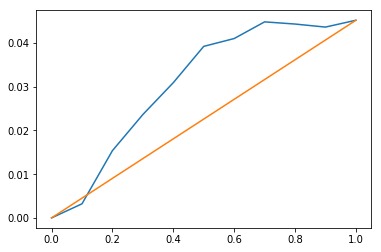

   pr_y1_t1  pr_y1_t0
0  0.243593  0.179598
1  0.157560  0.155070
2  0.163740  0.099698
3  0.100295  0.034678
4  0.145243  0.065182
       n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
group                                                            
1           84       58  0.207921  0.128889   404   450  0.079032
2           91       45  0.209195  0.107399   435   419  0.101797
3           76       37  0.177156  0.087059   429   425  0.090097
4           66       40  0.152778  0.094787   432   422  0.057991
5           72       31  0.159292  0.077114   452   402  0.082178


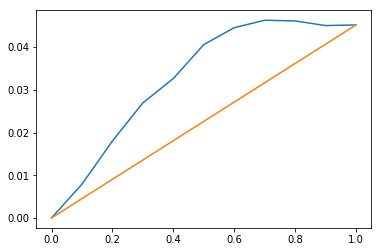

   pr_y1_t1  pr_y1_t0
0  0.154636  0.070087
1  0.202492  0.132765
2  0.198584  0.227283
3  0.241463  0.166460
4  0.165761  0.100741
       n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
group                                                            
1           89       65  0.219753  0.144766   405   449  0.074987
2           73       56  0.169374  0.132388   431   423  0.036986
3           71       43  0.172749  0.097065   411   443  0.075684
4           70       33  0.158014  0.080292   443   411  0.077722
5           83       23  0.187359  0.055961   443   411  0.131398


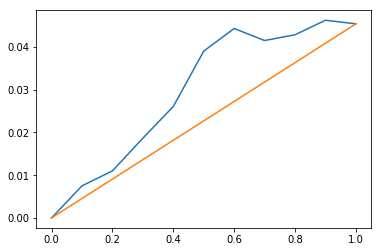

   pr_y1_t1  pr_y1_t0
0  0.091749  0.069584
1  0.132314  0.063997
2  0.173086  0.076581
3  0.093376  0.075376
4  0.196949  0.125696
       n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
group                                                            
1           77       47  0.185096  0.107306   416   438  0.077790
2           90       51  0.212766  0.118329   423   431  0.094436
3           68       50  0.162679  0.114679   418   436  0.048001
4           74       43  0.168565  0.103865   439   414  0.064700
5           66       35  0.148315  0.085575   445   409  0.062740


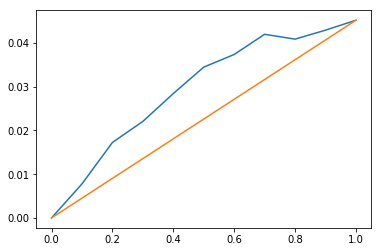

   pr_y1_t1  pr_y1_t0
0  0.172319  0.088897
1  0.113646  0.042267
2  0.136361  0.055810
3  0.125747  0.053976
4  0.078158  0.054360
       n_y1_t1  n_y1_t0   r_y1_t1   r_y1_t0  n_t1  n_t0    uplift
group                                                            
1           92       64  0.216471  0.149184   425   429  0.067286
2           78       59  0.177677  0.142169   439   415  0.035508
3           80       56  0.193705  0.127273   413   440  0.066432
4           81       28  0.173820  0.072165   466   388  0.101655
5           63       42  0.154034  0.094595   409   444  0.059440


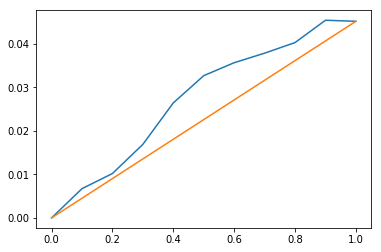

Model: tma

Tuning space: 

    'method': [<class 'sklearn.linear_model.logistic.LogisticRegression'>]

    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']

    'penalty': ['none', 'l2']

    'tol': [0.01, 0.001, 0.0001]

    'C': [1000000.0, 1000.0, 1, 0.001, 1e-06]

Seed: 1234

Qini values:  [0.008276744288062115, 0.01047067922145626, 0.007280192981595216, 0.0069777384025745195, 0.0048877030793830975]
Qini value: mean = 0.007578611594614241, std = 0.0018189301973819715




In [102]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split


def ty_assign(y, t):
    if y == 1 and t == 1:
        return "TR"
    elif y == 0 and t == 1:
        return "TN"
    elif y == 1 and t == 0:
        return "CR"
    elif y == 0 and t == 0:
        return "CN"
    else:
        return None
    
    
def main():
    ### Hyper parameters ###
    dataset = 'hillstrom'
    seed = 1234
    n_fold = 5
    models = {
        'tma': {'model': tma, 'predict': predict_tma}
    }
    search_space = {
        'method': [LogisticRegression],
        'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
        'penalty': ['none', 'l2'],
        'tol': [1e-2, 1e-3, 1e-4],
        'C': [1e6, 1e3, 1, 1e-3, 1e-6]
    }
    param_tuning = False

    # Preprocessing data & K fold validation
    if dataset == 'hillstrom':
        df_all = preprocess_data(hillstrom_df, dataset)
        #fold_split = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed).split(
        #    df_all.drop(columns=['T', 'Y']), df_all[['T','Y']].apply(lambda row: ty_assign(row['Y'], row['T']), axis=1))
        fold_split = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed).split(
            df_all, df_all['T'] * 2 + df_all['Y'])
    elif dataset == 'lalonde':
        df_all = preprocess_data(lalonde_df, dataset)
        fold_split = KFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_all)
    else:
        assert ()

    for model_name in models:
        qini_list = []
        best_params = {}

        for train_index, test_index in fold_split:
            if param_tuning:
                df_train = df_all.reindex(train_index).reset_index(drop=True)
                df_test = df_all.reindex(test_index).reset_index(drop=True)

                # Data split: 2/3 tuning dataset, 1/3 validation dataset
                stratify = pd.DataFrame([df_train['Y'], df_train['T']]).T
                df_tune, df_val = train_test_split(df_train, test_size=0.33, random_state=seed, stratify=stratify)

                # Variable selection (General wrapper approach)
                data_dict = {
                    "x_train": df_tune.drop(columns=['Y', 'T']).reset_index(drop=True),
                    "y_train": df_tune['Y'].reset_index(drop=True),
                    "t_train": df_tune['T'].reset_index(drop=True),
                    "x_test": df_val.drop(columns=['Y', 'T']).reset_index(drop=True),
                    "y_test": df_val['Y'].reset_index(drop=True),
                    "t_test": df_val['T'].reset_index(drop=True),
                }

                model_method = search_space.get('method', None)
                params = {
                    'method': None if model_method is None else model_method[0],
                }
                if params['method'] == LogisticRegression:
                    solver = search_space.get('solver', None)
                    params['solver'] = None if solver is None else solver[0]

                _, drop_vars, qini_values = wrapper(models[model_name]['model'],  models[model_name]['predict'],
                                                    data_dict, params=params)

                best_qini = max(qini_values)
                best_idx = qini_values.index(best_qini)
                best_drop_vars = drop_vars[: best_idx]

                data_dict['x_train'].drop(best_drop_vars, axis=1, inplace=True)
                data_dict['x_test'].drop(best_drop_vars, axis=1, inplace=True)
                df_train.drop(best_drop_vars, axis=1, inplace=True)
                df_test.drop(best_drop_vars, axis=1, inplace=True)

                # Parameter tuning
                _, best_params = parameter_tuning(models[model_name]['model'], models[model_name]['predict'],
                                                  data_dict, search_space=search_space)
            else:
                if model_name == 'tma':
                    best_params = {
                        'method': LogisticRegression,
                        'solver': 'newton-cg',
                        'C': 1e8
                    }

            # Train model and predict
            x_train = df_all.drop(columns=['T', 'Y']).reindex(train_index).reset_index(drop=True)
            y_train = df_all['Y'].reindex(train_index).reset_index(drop=True)
            t_train = df_all['T'].reindex(train_index).reset_index(drop=True)

            x_test = df_all.drop(columns=['T', 'Y']).reindex(test_index).reset_index(drop=True)
            y_test = df_all['Y'].reindex(test_index).reset_index(drop=True)
            t_test = df_all['T'].reindex(test_index).reset_index(drop=True)

            model = models[model_name]['model'](x_train, y_train, t_train, **best_params)
            pred = models[model_name]['predict'](model, x_test)
            print(pred[:5])

            # Calculate qini value
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
            print(perf[:5])
            q = qini(perf)
            qini_list.append(q['qini'])

        print("Model: {}\n".format(model_name))
        print("Tuning space: \n")
        for key, val in search_space.items():
            print("    '{}': {}\n".format(key, val))
        print("Seed: {}\n".format(seed))
        print('Qini values: ', qini_list)
        print("Qini value: mean = {}, std = {}\n\n".format(np.mean(qini_list), np.std(qini_list)))


main()

In [83]:
def main_basic_tree():
    ### Hyper parameters ###
    dataset = 'hillstrom'
    seed = 1234
    n_fold = 5

    # Preprocessing data & K fold validation
    if dataset == 'hillstrom':
        df_all = preprocess_data(hillstrom_df, dataset)
        fold_split = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed).split(
            df_all.drop(columns=['T', 'Y']), df_all[['T','Y']].apply(lambda row: ty_assign(row['Y'], row['T']), axis=1))
    elif dataset == 'lalonde':
        df_all = preprocess_data(lalonde_df, dataset)
        fold_split = KFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_all)
    else:
        assert()

    for train_index, test_index in fold_split:
        # Drop history column due to too slow learning speed
        df_train = df_all.reindex(train_index).reset_index(drop=True).drop(['history'], axis=1)
        df_test = df_all.reindex(test_index).reset_index(drop=True).drop(['history'], axis=1)

        y_test = df_all['Y'].reindex(test_index).reset_index(drop=True)
        t_test = df_all['T'].reindex(test_index).reset_index(drop=True)

        assert ((df_train.columns == df_test.columns).all())

        # Build decision tree and predict
        attributes = [col for col in df_train.columns if col != 'Y']
        #root = build_tree(df_train, attributes, 'Y')
        root = build_delta_delta_p_tree(df_train, attributes, 'Y')
        pred = test_predictions(root, df_test)
        print('pred: {}'.format(pred[: 5]))


main_basic_tree()

pred: 0    0.070838
1    0.017714
2    0.005058
3    0.070838
4    0.005058
dtype: float64
pred: 0    0.044523
1    0.029700
2    0.044523
3    0.074758
4    0.074758
dtype: float64
pred: 0    0.075799
1    0.048359
2    0.018660
3    0.048359
4    0.048359
dtype: float64
pred: 0    0.005615
1    0.050093
2    0.121615
3    0.005615
4    0.050093
dtype: float64
pred: 0    0.080943
1    0.080943
2    0.080943
3    0.080943
4    0.022786
dtype: float64


In [98]:
def main_tree():
    ### Hyper parameters ###
    dataset = 'hillstrom'
    seed = 1234
    n_fold = 5
    models = {
        'tma': {'model': uplift_tree_tma, 'predict': predict_tree_tma}
    }

    # Preprocessing data & K fold validation
    if dataset == 'hillstrom':
        df_all = preprocess_data(hillstrom_df, dataset)
        fold_split = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_all, df_all['Y'])
    elif dataset == 'lalonde':
        df_all = preprocess_data(lalonde_df, dataset)
        fold_split = KFold(n_splits=n_fold, shuffle=True, random_state=seed).split(df_all)
    else:
        assert ()

    for model_name in models:
        qini_list = []

        for train_index, test_index in fold_split:
            # Drop history column due to too slow learning speed
            df_train = df_all.reindex(train_index).reset_index(drop=True).drop(['history'], axis=1)
            df_test = df_all.reindex(test_index).reset_index(drop=True).drop(['history'], axis=1)

            x_train = df_train.drop(columns=['T', 'Y'])
            y_train = df_train['Y'].reindex(train_index)
            t_train = df_train['T'].reindex(train_index)

            x_test = df_test.drop(columns=['T', 'Y'])
            y_test = df_test['Y']
            t_test = df_test['T']

            # Build decision tree and predict on Two Model approach
            best_params = {}
            model = models[model_name]['model'](x_train, y_train, t_train, **best_params)
            pred = models[model_name]['predict'](model, x_test)

            # Calculate qini value
            perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], y_test, t_test)
            q = qini(perf)
            qini_list.append(q['qini'])

        print("Model: {}\n".format(model_name))
        print("Seed: {}\n".format(seed))
        print('Qini values: ', qini_list)
        print("Qini value: mean = {}, std = {}\n\n".format(np.mean(qini_list), np.std(qini_list)))


main_tree()

NameError: ignored

In [1]:
def main_uplift():
    df = pd.read_csv('Hillstrom.csv')
    dataset = 'hillstrom'
    df = preprocess_data(df)
    Y = df['Y']
    T = df['T']
    X = df.drop(['Y', 'T'], axis=1)
    ty = pd.DataFrame({'Y': Y, 'T': T})\
             .apply(lambda row: ty_assign(row['Y'], row['T']), axis=1)
    fold_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234).split(X, ty)

    ### Cross validation ###
    qini_list = []
    for idx, (train_index, test_index) in enumerate(fold_gen):
        X_train = X.reindex(train_index)
        X_test = X.reindex(test_index)
        Y_train = Y.reindex(train_index)
        Y_test = Y.reindex(test_index)
        T_train = T.reindex(train_index)
        T_test = T.reindex(test_index)

        mdl = uplift_tree(X_train, Y_train, T_train)
        pred = predict_tree(mdl, X_test)
        print(pred[: 5])
        perf = performance(pred['pr_y1_t1'], pred['pr_y1_t0'], Y_test, T_test)
        print(perf[: 5])
        q = qini(perf)
        qini_list.append(q['qini'])
    print('Qini values: ', qini_list)
    print('    mean: {}, std: {}'.format(np.mean(qini_list), np.std(qini_list)))


main_uplift()

NameError: ignored